# MLB Salary (AAV) Prediction Model

This notebook predicts player **Annual Average Value (AAV)** using performance metrics.

**Data Split Strategy:**
- **Training Set**: ≤2023 seasons (historical data)
- **Validation Set**: 2024 season (model selection & tuning)
- **Prediction Set**: 2025 season (final evaluation)

**Models**: Gradient Boosting Regressor with log-transformed salary target


## 1. Hitter Data Preparation

In [ ]:
import pandas as pd
import numpy as np

# Load the hitters data with contracts
hitters_df = pd.read_csv('data/Hitters_Training_Data.csv')

print(f"Total hitters: {len(hitters_df)}")
print(f"Hitters with AnnualValue: {hitters_df['AnnualValue'].notna().sum()}")
print(f"Hitters without AnnualValue: {hitters_df['AnnualValue'].isna().sum()}")
print(f"\nMatch rate: {hitters_df['AnnualValue'].notna().sum() / len(hitters_df) * 100:.1f}%")
print(hitters_df["AnnualValue"].notna())

Total hitters: 1867
Hitters with AnnualValue: 1867
Hitters without AnnualValue: 0

Match rate: 100.0%
0       True
1       True
2       True
3       True
4       True
        ... 
1862    True
1863    True
1864    True
1865    True
1866    True
Name: AnnualValue, Length: 1867, dtype: bool


In [38]:
# View all column names
print("All columns:")
print(hitters_df.columns.tolist())

# View a row that has AnnualValue to see available data
print("\nSample row with AnnualValue:")
sample = hitters_df[hitters_df['AnnualValue'].notna()].iloc[0]
print(sample)


All columns:
['Name', 'Age', '#days', 'Lev', 'Tm', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'mlbID', 'Name_bat', 'swings_competitive', 'percent_swings_competitive', 'contact', 'avg_bat_speed', 'hard_swing_rate', 'squared_up_per_bat_contact', 'squared_up_per_swing', 'blast_per_bat_contact', 'blast_per_swing', 'swing_length', 'swords', 'batter_run_value', 'whiffs', 'whiff_per_swing', 'batted_ball_events', 'batted_ball_event_per_swing', 'Name_ev', 'attempts', 'avg_hit_angle', 'anglesweetspotpercent', 'max_hit_speed', 'avg_hit_speed', 'ev50', 'fbld', 'gb', 'max_distance', 'avg_distance', 'avg_hr_distance', 'ev95plus', 'ev95percent', 'barrels', 'brl_percent', 'brl_pa', 'Name_x', 'year', 'pa', 'bip', 'ba', 'est_ba', 'est_ba_minus_ba_diff', 'slg', 'est_slg', 'est_slg_minus_slg_diff', 'woba', 'est_woba', 'est_woba_minus_woba_diff', 'Name_sprint', 'team_id', 'team', 'position', 'age', 'competitive_run

In [39]:
# Filter to only hitters with salary data
hitters_with_salary = hitters_df[hitters_df['AnnualValue'].notna()].copy()

print(f"Hitters with salary data: {len(hitters_with_salary)}")
print(f"\nSalary distribution:")
print(hitters_with_salary['AnnualValue'].describe())

print(f"\nBy season:")
print(hitters_with_salary.groupby('Season').size())


Hitters with salary data: 1867

Salary distribution:
count    1.867000e+03
mean     4.215128e+06
std      7.255832e+06
min      8.000000e+03
25%      7.400000e+05
50%      7.670000e+05
75%      4.000000e+06
max      7.000000e+07
Name: AnnualValue, dtype: float64

By season:
Season
2023    615
2024    613
2025    639
dtype: int64


In [40]:
# View ALL players without salary data
missing_salary = hitters_df[hitters_df['AnnualValue'].isna()][['Name', 'Tm', 'Season', 'PA', 'WAR']]
print(f"Players without salary data ({len(missing_salary)} total):\n")

# Show all players sorted by WAR
pd.set_option('display.max_rows', None)
display(missing_salary.sort_values('WAR', ascending=False))
pd.reset_option('display.max_rows')


Players without salary data (0 total):



,Name,Tm,Season,PA,WAR


In [41]:

hitters_with_salary.to_csv('data/Hitters_Training_Data.csv', index=False)
print(f"Saved {len(hitters_with_salary)} hitters with salary data to 'data/Hitters_Training_Data.csv'")

# Preview the data
print(f"\nSample of training data:")
hitters_with_salary[['Name', 'Season', 'PA', 'WAR', 'OPS', 'AnnualValue']].head(10)

Saved 1867 hitters with salary data to 'data/Hitters_Training_Data.csv'

Sample of training data:


,Name,Season,PA,WAR,OPS,AnnualValue
0,CJ Abrams,2023,614,3.45,0.712,724200.0
1,Jos\xc3\xa9 Abreu,2023,642,-0.09,0.700,19500000.0
2,Wilyer Abreu,2023,85,0.67,0.862,720000.0
3,Ronald Acu\xc3\xb1a Jr.,2023,752,8.40,1.001,17000000.0
4,Willy Adames,2023,646,2.91,0.724,8700000.0
5,Jordyn Adams,2023,40,-0.71,0.253,720000.0
6,Riley Adams,2023,158,1.07,0.807,728800.0
7,Jo Adell,2023,62,0.34,0.706,720000.0
8,Jes\xc3\xbas Aguilar,2023,115,-0.60,0.665,3000000.0
9,Nick Ahmed,2023,210,-0.26,0.560,10625000.0


## 2. Pitcher Data Preparation


In [42]:
import unicodedata
import re
import codecs

def fix_escaped_unicode(name):
    """Decode escaped UTF-8 bytes back to proper unicode"""
    if pd.isna(name):
        return ''
    name = str(name)
    if '\\x' in name:
        try:
            name = codecs.decode(name, 'unicode_escape')
            name = name.encode('latin-1').decode('utf-8')
        except:
            pass
    return name

def extract_spotrac_name(name):
    """Fix Spotrac format: 'LastName Suffix FirstName LastName' -> 'FirstName LastName'"""
    if pd.isna(name):
        return ''
    name = str(name).strip()
    
    # Remove leading numbers
    name = re.sub(r'^\d+\s+', '', name)
    
    # Handle suffix patterns (Jr., II, etc.)
    suffix_patterns = [r'\s+Jr\.?\s+', r'\s+Sr\.?\s+', r'\s+II\s+', r'\s+III\s+', r'\s+IV\s+']
    for pattern in suffix_patterns:
        match = re.search(pattern, name, re.IGNORECASE)
        if match:
            after = name[match.end():].strip()
            if after:
                return after
    
    # Handle repeated name pattern (no suffix)
    words = name.split()
    if len(words) >= 3:
        for i in range(1, len(words) // 2 + 1):
            start_part = ' '.join(words[:i]).lower()
            end_part = ' '.join(words[-i:]).lower()
            if start_part == end_part:
                return ' '.join(words[i:])
    return name

def normalize_name(name, is_contract=False):
    """Normalize name for matching between datasets"""
    if pd.isna(name):
        return ''
    
    name = fix_escaped_unicode(name)
    if is_contract:
        name = extract_spotrac_name(name)
    
    name = unicodedata.normalize('NFD', name)
    name = ''.join(c for c in name if unicodedata.category(c) != 'Mn')
    name = name.lower()
    
    # Remove middle initials and periods
    name = re.sub(r'\b\w\.\s*', '', name)
    name = name.replace('.', '')
    name = re.sub(r'[^\w\s]', '', name)
    
    # Remove suffixes at end
    for suffix in [' jr', ' sr', ' iii', ' ii', ' iv']:
        if name.endswith(suffix):
            name = name[:-len(suffix)]
    
    return ' '.join(name.split()).strip()

# Load pitcher data
pitchers_df = pd.read_csv('data/Pitchers_2015-2025_byYear_retry.csv')
pitcher_contracts = pd.read_csv('data/Pitcher_Contracts_2015-2025.csv')

print(f"Pitchers data: {len(pitchers_df)} records")
print(f"Pitcher contracts: {len(pitcher_contracts)} records")
print(f"\nPitcher years: {sorted(pitchers_df['Season'].unique())}")


Pitchers data: 8968 records
Pitcher contracts: 9635 records

Pitcher years: [np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [43]:
# Normalize names for matching
pitchers_df['Name_match'] = pitchers_df['Name'].apply(lambda x: normalize_name(x, is_contract=False))
pitcher_contracts['Name_match'] = pitcher_contracts['Name'].apply(lambda x: normalize_name(x, is_contract=True))

# Ensure Season is int
pitcher_contracts['Season'] = pitcher_contracts['Season'].astype(int)
pitchers_df['Season'] = pitchers_df['Season'].astype(int)

# Merge on normalized name and season
pitchers_merged = pitchers_df.merge(
    pitcher_contracts[['Name_match', 'Season', 'Salary', 'AnnualValue', 'Position']],
    on=['Name_match', 'Season'],
    how='left',
    suffixes=('', '_contract')
)

# Drop the match column
pitchers_merged = pitchers_merged.drop(columns=['Name_match'])

# Stats
matched = pitchers_merged['AnnualValue'].notna().sum()
total = len(pitchers_merged)
print(f"Total pitchers: {total}")
print(f"Pitchers with AnnualValue: {matched}")
print(f"Pitchers without AnnualValue: {total - matched}")
print(f"\nMatch rate: {matched/total*100:.1f}%")

print(f"\nBy season:")
print(pitchers_merged.groupby('Season').apply(lambda x: f"{x['AnnualValue'].notna().sum()}/{len(x)}"))


Total pitchers: 9313
Pitchers with AnnualValue: 8666
Pitchers without AnnualValue: 647

Match rate: 93.1%

By season:
Season
2015    700/743
2016    730/763
2017    752/785
2018    764/822
2019    784/849
2020    713/749
2021    875/950
2022    842/923
2023    828/901
2024    840/903
2025    838/925
dtype: object


In [44]:
# Filter to only pitchers with salary data
pitchers_with_salary = pitchers_merged[pitchers_merged['AnnualValue'].notna()].copy()

print(f"Pitchers with salary data: {len(pitchers_with_salary)}")
print(f"\nSalary distribution:")
print(pitchers_with_salary['AnnualValue'].describe())

# View players without salary (top by WAR)
missing_salary = pitchers_merged[pitchers_merged['AnnualValue'].isna()][['Name', 'Tm', 'Season', 'IP', 'WAR']]
print(f"\nTop 20 pitchers without salary data (by WAR):")
display(missing_salary.sort_values('WAR', ascending=False).head(20))


Pitchers with salary data: 8666

Salary distribution:
count    8.666000e+03
mean     2.473676e+06
std      4.641804e+06
min      2.773000e+03
25%      5.550000e+05
50%      7.200000e+05
75%      1.750000e+06
max      4.333333e+07
Name: AnnualValue, dtype: float64

Top 20 pitchers without salary data (by WAR):


,Name,Tm,Season,IP,WAR
6265,Shohei Ohtani,Los Angeles,2022,166.0,6.22
3769,Hyun Jin Ryu,Los Angeles,2019,182.2,5.14
2517,Mike Fiers,"Detroit,Oakland",2018,172.0,4.38
5329,Shohei Ohtani,Los Angeles,2021,130.1,4.07
7168,Shohei Ohtani,Los Angeles,2023,132.0,3.85
3353,Mike Fiers,Oakland,2019,184.2,3.36
4546,Hyun Jin Ryu,Toronto,2020,67.0,2.90
2934,Hyun Jin Ryu,Los Angeles,2018,82.1,2.17
9295,Simeon Woods Richardson,Minnesota,2025,111.1,2.16
2666,Jakob Junis,Kansas City,2018,177.0,2.09


In [45]:
# Save pitcher training data
pitchers_with_salary.to_csv('data/Pitchers_Training_Data.csv', index=False)
print(f"Saved {len(pitchers_with_salary)} pitchers with salary data to 'data/Pitchers_Training_Data.csv'")

# Also save the full merged data (with missing salaries)
pitchers_merged.to_csv('data/Pitchers_with_Contracts.csv', index=False)
print(f"Saved {len(pitchers_merged)} total pitcher records to 'data/Pitchers_with_Contracts.csv'")

# Preview the training data
print(f"\nSample of pitcher training data:")
pitchers_with_salary[['Name', 'Season', 'IP', 'ERA', 'SO', 'WAR', 'AnnualValue']].head(10)


Saved 8666 pitchers with salary data to 'data/Pitchers_Training_Data.csv'
Saved 9313 total pitcher records to 'data/Pitchers_with_Contracts.csv'

Sample of pitcher training data:


,Name,Season,IP,ERA,SO,WAR,AnnualValue
1,Fernando Abad,2015,47.2,4.15,45,0.18,1087500.0
2,A.J. Achter,2015,13.1,6.75,14,-0.18,507500.0
3,Austin Adams,2015,33.1,3.78,23,0.30,507700.0
4,Nathan Adcock,2015,18.0,6.00,13,-0.22,332786.0
5,Jeremy Affeldt,2015,35.1,5.86,21,-0.80,5000000.0
6,Andrew Albers,2015,2.2,3.38,1,0.04,507500.0
7,Matt Albers,2015,37.1,1.21,28,1.42,1500000.0
8,Al Alburquerque,2015,62.0,4.21,58,0.35,1725000.0
9,Scott Alexander,2015,6.0,4.50,3,0.02,507500.0
10,Cody Allen,2015,70.0,2.96,99,1.25,547100.0


## 3. Hitter Salary Model

### 3.1 Feature Selection & Data Split


In [46]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load hitter training data
hitters = pd.read_csv('data/Hitters_Training_Data.csv')

# Define features for hitters
hitter_features = ['Age', 'G', 'PA', 'WAR']

# Check which features are available
available_features = [f for f in hitter_features if f in hitters.columns]
missing_features = [f for f in hitter_features if f not in hitters.columns]

print(f"Available features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Prepare data - drop rows with missing values in features
df = hitters[['Name', 'Season', 'AnnualValue'] + available_features].copy()
df = df.dropna(subset=available_features + ['AnnualValue'])

# Log transform target
df['log_salary'] = np.log(df['AnnualValue'])

print(f"\nData shape after cleaning: {df.shape}")
print(f"\nSalary distribution:")
print(df['AnnualValue'].describe())


Available features (4): ['Age', 'G', 'PA', 'WAR']

Data shape after cleaning: (1867, 8)

Salary distribution:
count    1.867000e+03
mean     4.215128e+06
std      7.255832e+06
min      8.000000e+03
25%      7.400000e+05
50%      7.670000e+05
75%      4.000000e+06
max      7.000000e+07
Name: AnnualValue, dtype: float64


In [47]:
# Temporal split: Train ≤2023, Validate 2024, Predict 2025
train_df = df[df['Season'] <= 2023]
val_df = df[df['Season'] == 2024]
predict_df = df[df['Season'] == 2025]

print(f"Training set: {len(train_df)} samples (≤2023)")
print(f"Validation set: {len(val_df)} samples (2024)")
print(f"Prediction set: {len(predict_df)} samples (2025)")

# Prepare X and y for training/validation
X_train = train_df[available_features]
y_train = train_df['log_salary']
X_val = val_df[available_features]
y_val = val_df['log_salary']
X_pred = predict_df[available_features]
y_pred_true = predict_df['log_salary']

# Keep original salaries for evaluation
y_train_orig = train_df['AnnualValue']
y_val_orig = val_df['AnnualValue']
y_pred_orig = predict_df['AnnualValue']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_pred_scaled = scaler.transform(X_pred)

print(f"\nFeature matrix shape: {X_train_scaled.shape}")


Training set: 615 samples (≤2023)
Validation set: 613 samples (2024)
Prediction set: 639 samples (2025)

Feature matrix shape: (615, 4)


In [48]:
import matplotlib.pyplot as plt

def evaluate_model(y_true_log, y_pred_log, y_true_orig):
    """Evaluate model on both log and original scale"""
    y_pred_orig = np.exp(y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100
    return {'RMSE (log)': rmse_log, 'RMSE ($)': rmse, 'MAE ($)': mae, 'R²': r2, 'MAPE (%)': mape}

# Train Gradient Boosting model
print("Training Gradient Boosting on ≤2023 data...")
model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict on validation (2024) and prediction (2025) sets
y_val_pred = model.predict(X_val)
y_2025_pred = model.predict(X_pred)

# Evaluate on both sets
val_metrics = evaluate_model(y_val, y_val_pred, y_val_orig)
pred_metrics = evaluate_model(y_pred_true, y_2025_pred, y_pred_orig)

print("\n" + "="*70)
print("HITTER SALARY MODEL PERFORMANCE")
print("="*70)
print(f"\n{'Metric':<20} {'Validation (2024)':<20} {'Prediction (2025)':<20}")
print("-"*60)
print(f"{'R²':<20} {val_metrics['R²']:<20.3f} {pred_metrics['R²']:<20.3f}")
print(f"{'RMSE':<20} ${val_metrics['RMSE ($)']:>15,.0f}    ${pred_metrics['RMSE ($)']:>15,.0f}")
print(f"{'MAE':<20} ${val_metrics['MAE ($)']:>15,.0f}    ${pred_metrics['MAE ($)']:>15,.0f}")
print(f"{'MAPE':<20} {val_metrics['MAPE (%)']:>15.1f}%    {pred_metrics['MAPE (%)']:>15.1f}%")

Training Gradient Boosting on ≤2023 data...

HITTER SALARY MODEL PERFORMANCE

Metric               Validation (2024)    Prediction (2025)   
------------------------------------------------------------
R²                   0.397                0.434               
RMSE                 $      5,788,675    $      5,622,528
MAE                  $      2,699,196    $      2,485,194
MAPE                            96.7%              107.1%


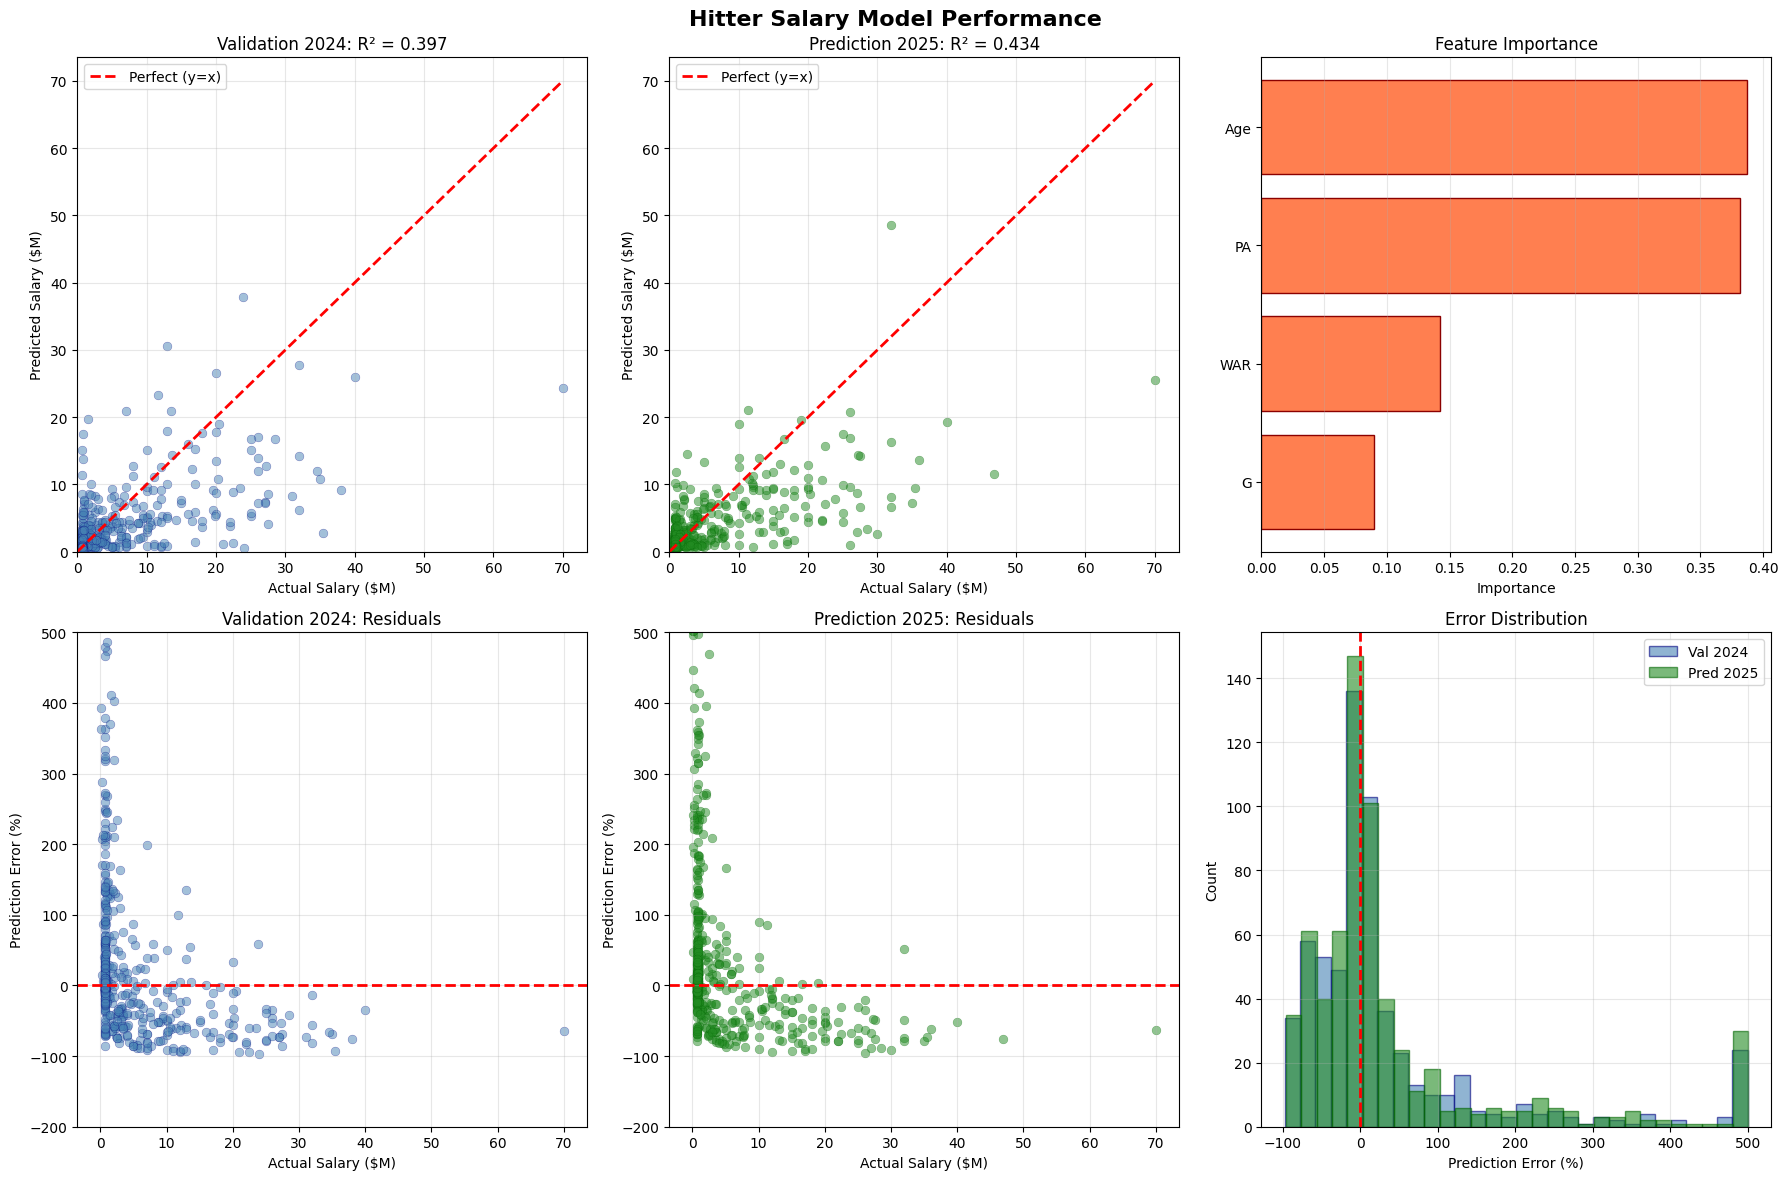

In [49]:
# Create comparison dataframes for validation and prediction sets
val_comp = val_df[['Name', 'Season', 'AnnualValue', 'WAR']].copy()
val_comp['Predicted'] = np.exp(y_val_pred)
val_comp['Error'] = val_comp['Predicted'] - val_comp['AnnualValue']
val_comp['Pct_Error'] = (val_comp['Error'] / val_comp['AnnualValue']) * 100

pred_comp = predict_df[['Name', 'Season', 'AnnualValue', 'WAR']].copy()
pred_comp['Predicted'] = np.exp(y_2025_pred)
pred_comp['Error'] = pred_comp['Predicted'] - pred_comp['AnnualValue']
pred_comp['Pct_Error'] = (pred_comp['Error'] / pred_comp['AnnualValue']) * 100

# ============ COMPREHENSIVE PLOTS ============
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hitter Salary Model Performance', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted - Validation (2024)
ax1 = axes[0, 0]
ax1.scatter(val_comp['AnnualValue'] / 1e6, val_comp['Predicted'] / 1e6, 
            alpha=0.5, s=40, c='steelblue', edgecolors='navy', linewidth=0.3)
max_val = max(val_comp['AnnualValue'].max(), val_comp['Predicted'].max()) / 1e6
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect (y=x)')
ax1.set_xlabel('Actual Salary ($M)')
ax1.set_ylabel('Predicted Salary ($M)')
ax1.set_title(f'Validation 2024: R² = {val_metrics["R²"]:.3f}')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max_val * 1.05)
ax1.set_ylim(0, max_val * 1.05)

# Plot 2: Actual vs Predicted - Prediction (2025)
ax2 = axes[0, 1]
ax2.scatter(pred_comp['AnnualValue'] / 1e6, pred_comp['Predicted'] / 1e6, 
            alpha=0.5, s=40, c='forestgreen', edgecolors='darkgreen', linewidth=0.3)
max_val = max(pred_comp['AnnualValue'].max(), pred_comp['Predicted'].max()) / 1e6
ax2.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect (y=x)')
ax2.set_xlabel('Actual Salary ($M)')
ax2.set_ylabel('Predicted Salary ($M)')
ax2.set_title(f'Prediction 2025: R² = {pred_metrics["R²"]:.3f}')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, max_val * 1.05)
ax2.set_ylim(0, max_val * 1.05)

# Plot 3: Feature Importance
ax3 = axes[0, 2]
importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=True)
ax3.barh(importance['Feature'], importance['Importance'], color='coral', edgecolor='darkred')
ax3.set_xlabel('Importance')
ax3.set_title('Feature Importance')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Residual Plot (% Error) - Validation
ax4 = axes[1, 0]
ax4.scatter(val_comp['AnnualValue'] / 1e6, val_comp['Pct_Error'], 
            alpha=0.5, s=40, c='steelblue', edgecolors='navy', linewidth=0.3)
ax4.axhline(y=0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Actual Salary ($M)')
ax4.set_ylabel('Prediction Error (%)')
ax4.set_title('Validation 2024: Residuals')
ax4.set_ylim(-200, 500)
ax4.grid(True, alpha=0.3)

# Plot 5: Residual Plot (% Error) - Prediction
ax5 = axes[1, 1]
ax5.scatter(pred_comp['AnnualValue'] / 1e6, pred_comp['Pct_Error'], 
            alpha=0.5, s=40, c='forestgreen', edgecolors='darkgreen', linewidth=0.3)
ax5.axhline(y=0, color='red', linestyle='--', lw=2)
ax5.set_xlabel('Actual Salary ($M)')
ax5.set_ylabel('Prediction Error (%)')
ax5.set_title('Prediction 2025: Residuals')
ax5.set_ylim(-200, 500)
ax5.grid(True, alpha=0.3)

# Plot 6: Error Distribution (both sets)
ax6 = axes[1, 2]
ax6.hist(val_comp['Pct_Error'].clip(-200, 500), bins=30, alpha=0.6, 
         color='steelblue', label='Val 2024', edgecolor='navy')
ax6.hist(pred_comp['Pct_Error'].clip(-200, 500), bins=30, alpha=0.6, 
         color='forestgreen', label='Pred 2025', edgecolor='darkgreen')
ax6.axvline(x=0, color='red', linestyle='--', lw=2)
ax6.set_xlabel('Prediction Error (%)')
ax6.set_ylabel('Count')
ax6.set_title('Error Distribution')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [50]:
# Format prediction set (2025) for display
pred_display = pred_comp.copy()
pred_display['Actual'] = pred_display['AnnualValue'].apply(lambda x: f"${x/1e6:.1f}M")
pred_display['Pred'] = pred_display['Predicted'].apply(lambda x: f"${x/1e6:.1f}M")
pred_display['Diff'] = pred_display['Error'].apply(lambda x: f"${x/1e6:+.1f}M")

print("="*70)
print("2025 PREDICTIONS - Top 10 Highest Paid Hitters")
print("="*70)
top_paid = pred_comp.nlargest(10, 'AnnualValue')
display(pred_display.loc[top_paid.index][['Name', 'WAR', 'Actual', 'Pred', 'Diff']])

print("\n" + "="*70)
print("MOST OVERPAID (Model predicts lower salary)")
print("="*70)
overpaid = pred_comp.nsmallest(10, 'Error')
display(pred_display.loc[overpaid.index][['Name', 'WAR', 'Actual', 'Pred', 'Diff']])

print("\n" + "="*70)
print("BEST VALUE / UNDERPAID (Model predicts higher salary)")
print("="*70)
underpaid = pred_comp.nlargest(10, 'Error')
display(pred_display.loc[underpaid.index][['Name', 'WAR', 'Actual', 'Pred', 'Diff']])


2025 PREDICTIONS - Top 10 Highest Paid Hitters


,Name,WAR,Actual,Pred,Diff
1640,Shohei Ohtani,6.62,$70.0M,$25.6M,$-44.4M
1755,Juan Soto,6.24,$46.9M,$11.6M,$-35.3M
1498,Aaron Judge,9.70,$40.0M,$19.4M,$-20.6M
1346,Carlos Correa,1.46,$36.0M,$13.7M,$-22.3M
1803,Mike Trout,1.51,$35.5M,$9.5M,$-26.0M
1294,Alex Bregman,3.46,$35.0M,$7.3M,$-27.7M
1253,Nolan Arenado,1.29,$32.0M,$8.1M,$-23.9M
1539,Francisco Lindor,5.87,$32.0M,$16.3M,$-15.7M
1732,Corey Seager,6.15,$32.0M,$48.6M,$+16.6M
1759,Giancarlo Stanton,1.87,$32.0M,$6.7M,$-25.3M



MOST OVERPAID (Model predicts lower salary)


,Name,WAR,Actual,Pred,Diff
1640,Shohei Ohtani,6.62,$70.0M,$25.6M,$-44.4M
1755,Juan Soto,6.24,$46.9M,$11.6M,$-35.3M
1294,Alex Bregman,3.46,$35.0M,$7.3M,$-27.7M
1242,Jose Altuve,0.49,$30.0M,$2.7M,$-27.3M
1803,Mike Trout,1.51,$35.5M,$9.5M,$-26.0M
1759,Giancarlo Stanton,1.87,$32.0M,$6.7M,$-25.3M
1435,Vladimir Guerrero Jr.,4.58,$28.5M,$3.3M,$-25.2M
1301,Kris Bryant,-0.52,$26.0M,$1.0M,$-25.0M
1771,Dansby Swanson,4.48,$27.0M,$2.9M,$-24.1M
1253,Nolan Arenado,1.29,$32.0M,$8.1M,$-23.9M



BEST VALUE / UNDERPAID (Model predicts higher salary)


,Name,WAR,Actual,Pred,Diff
1732,Corey Seager,6.15,$32.0M,$48.6M,$+16.6M
1658,Geraldo Perdomo,7.02,$2.5M,$14.5M,$+12.0M
1673,Cal Raleigh,7.37,$1.0M,$11.9M,$+10.9M
1255,Randy Arozarena,4.03,$11.3M,$21.0M,$+9.7M
1722,Carlos Santana,1.10,$0.8M,$10.2M,$+9.4M
1372,Yandy D\xc3\xadaz,3.39,$10.0M,$19.0M,$+9.0M
1275,Joey Bart,0.52,$1.2M,$9.6M,$+8.4M
1434,Trent Grisham,3.52,$5.0M,$13.3M,$+8.3M
1704,Brent Rooker,2.31,$2.0M,$9.9M,$+7.9M
1774,Mike Tauchman,1.89,$1.9M,$8.3M,$+6.3M


## 4. Pitcher Salary Model

### 4.1 Feature Selection & Data Split


In [51]:
# Load pitcher training data
pitchers = pd.read_csv('data/Pitchers_Training_Data.csv')

# Define features for pitchers
pitcher_features = ['Age', 'G', 'IP', 'WAR']

# Check which features are available
available_p_features = [f for f in pitcher_features if f in pitchers.columns]
print(f"Available features ({len(available_p_features)}): {available_p_features}")

# Prepare data
df_p = pitchers[['Name', 'Season', 'AnnualValue'] + available_p_features].copy()
df_p = df_p.dropna(subset=available_p_features + ['AnnualValue'])
df_p['log_salary'] = np.log(df_p['AnnualValue'])

print(f"\nData shape after cleaning: {df_p.shape}")
print(f"\nPitcher salary distribution:")
print(df_p['AnnualValue'].describe())


Available features (4): ['Age', 'G', 'IP', 'WAR']

Data shape after cleaning: (7758, 8)

Pitcher salary distribution:
count    7.758000e+03
mean     2.508491e+06
std      4.726652e+06
min      2.773000e+03
25%      5.550000e+05
50%      7.200000e+05
75%      1.768750e+06
max      4.333333e+07
Name: AnnualValue, dtype: float64


In [52]:
# Temporal split: Train ≤2023, Validate 2024, Predict 2025
train_p = df_p[df_p['Season'] <= 2023]
val_p = df_p[df_p['Season'] == 2024]
predict_p = df_p[df_p['Season'] == 2025]

print(f"Training set: {len(train_p)} samples (≤2023)")
print(f"Validation set: {len(val_p)} samples (2024)")
print(f"Prediction set: {len(predict_p)} samples (2025)")

# Prepare X and y
X_train_p = train_p[available_p_features]
y_train_p = train_p['log_salary']
X_val_p = val_p[available_p_features]
y_val_p = val_p['log_salary']
X_pred_p = predict_p[available_p_features]
y_pred_p_true = predict_p['log_salary']

# Keep original salaries
y_train_p_orig = train_p['AnnualValue']
y_val_p_orig = val_p['AnnualValue']
y_pred_p_orig = predict_p['AnnualValue']

# Scale features
scaler_p = StandardScaler()
X_train_p_scaled = scaler_p.fit_transform(X_train_p)
X_val_p_scaled = scaler_p.transform(X_val_p)
X_pred_p_scaled = scaler_p.transform(X_pred_p)

# Train Gradient Boosting model
print("\nTraining Gradient Boosting on ≤2023 data...")
model_p = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
model_p.fit(X_train_p, y_train_p)

# Predict on validation (2024) and prediction (2025) sets
y_val_p_pred = model_p.predict(X_val_p)
y_2025_p_pred = model_p.predict(X_pred_p)

# Evaluate on both sets
val_p_metrics = evaluate_model(y_val_p, y_val_p_pred, y_val_p_orig)
pred_p_metrics = evaluate_model(y_pred_p_true, y_2025_p_pred, y_pred_p_orig)

print("\n" + "="*70)
print("PITCHER SALARY MODEL PERFORMANCE")
print("="*70)
print(f"\n{'Metric':<20} {'Validation (2024)':<20} {'Prediction (2025)':<20}")
print("-"*60)
print(f"{'R²':<20} {val_p_metrics['R²']:<20.3f} {pred_p_metrics['R²']:<20.3f}")
print(f"{'RMSE':<20} ${val_p_metrics['RMSE ($)']:>15,.0f}    ${pred_p_metrics['RMSE ($)']:>15,.0f}")
print(f"{'MAE':<20} ${val_p_metrics['MAE ($)']:>15,.0f}    ${pred_p_metrics['MAE ($)']:>15,.0f}")
print(f"{'MAPE':<20} {val_p_metrics['MAPE (%)']:>15.1f}%    {pred_p_metrics['MAPE (%)']:>15.1f}%")


Training set: 6220 samples (≤2023)
Validation set: 767 samples (2024)
Prediction set: 771 samples (2025)

Training Gradient Boosting on ≤2023 data...

PITCHER SALARY MODEL PERFORMANCE

Metric               Validation (2024)    Prediction (2025)   
------------------------------------------------------------
R²                   0.386                0.426               
RMSE                 $      3,982,194    $      3,892,575
MAE                  $      1,557,850    $      1,726,863
MAPE                           162.8%              122.0%


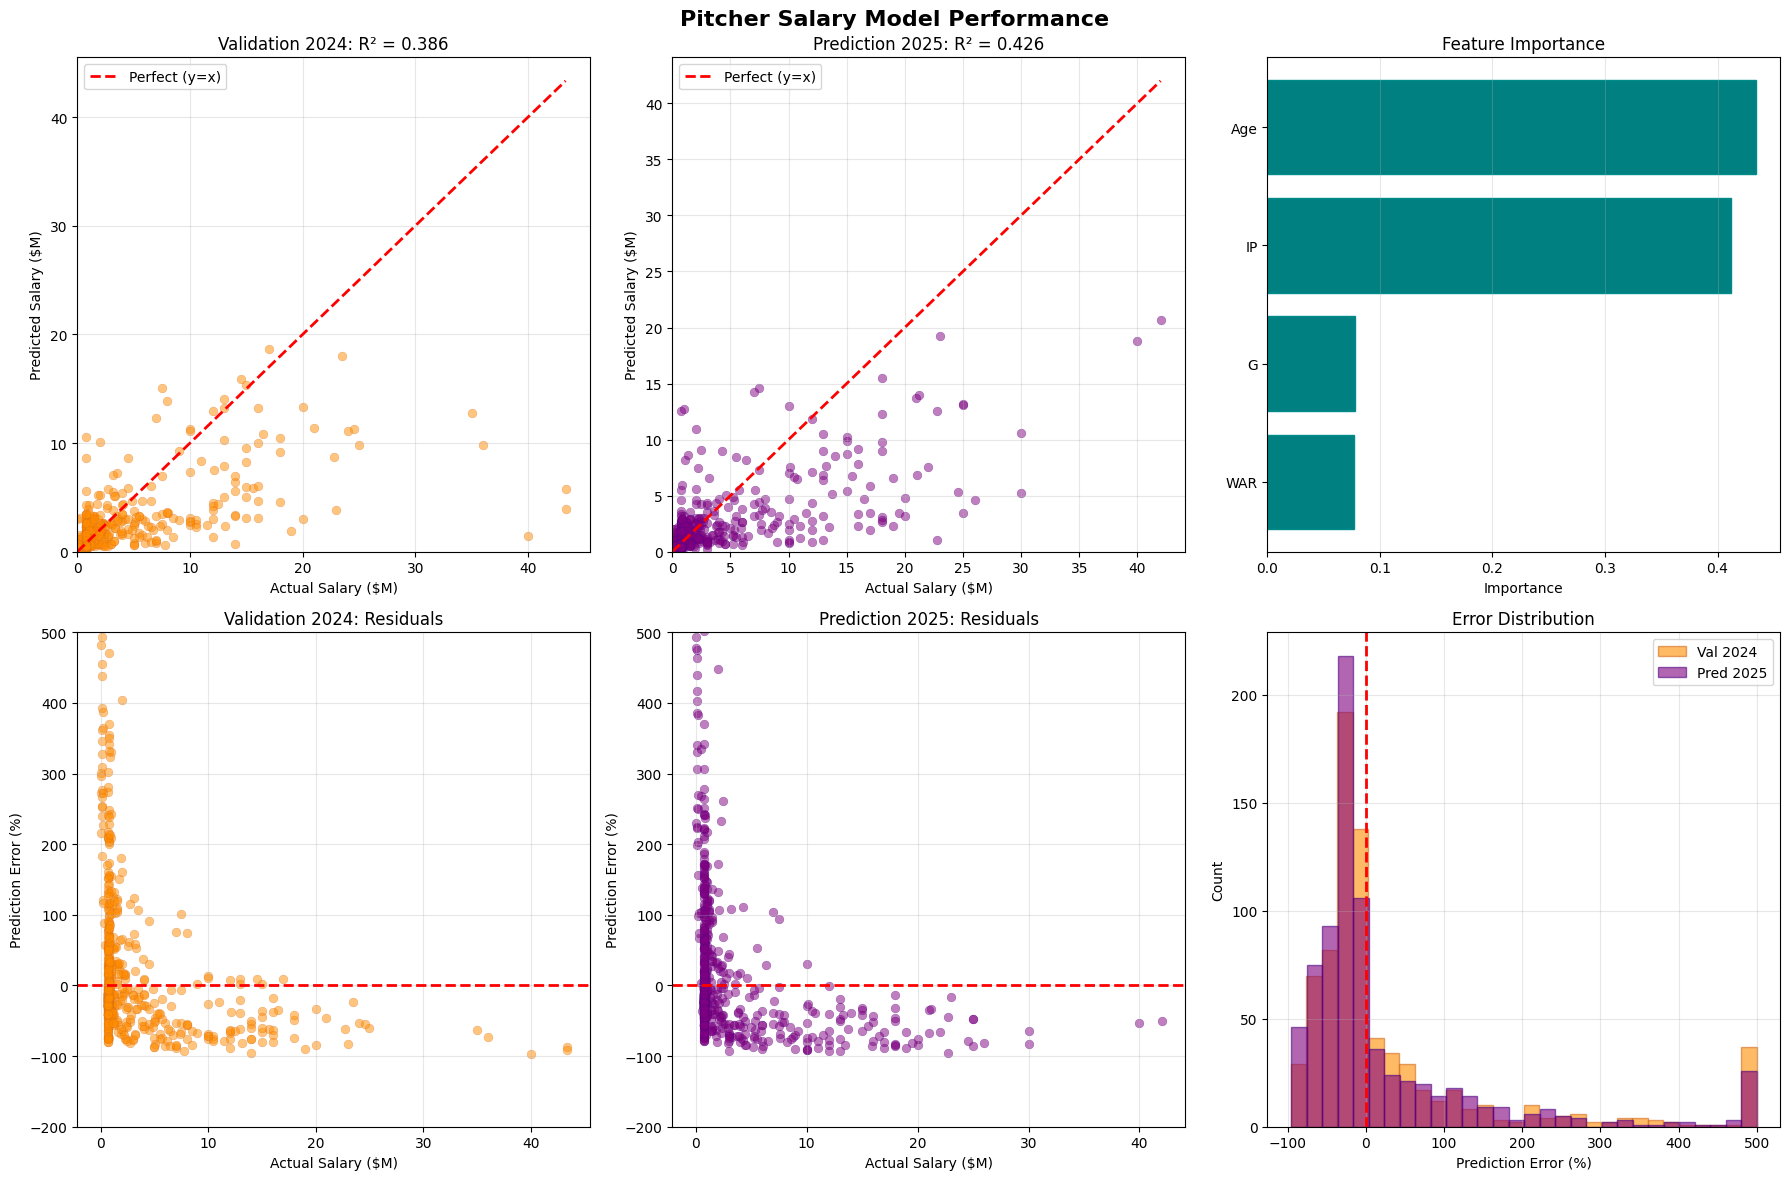

In [53]:
# Create comparison dataframes for validation and prediction sets
val_p_comp = val_p[['Name', 'Season', 'AnnualValue', 'WAR']].copy()
val_p_comp['Predicted'] = np.exp(y_val_p_pred)
val_p_comp['Error'] = val_p_comp['Predicted'] - val_p_comp['AnnualValue']
val_p_comp['Pct_Error'] = (val_p_comp['Error'] / val_p_comp['AnnualValue']) * 100

pred_p_comp = predict_p[['Name', 'Season', 'AnnualValue', 'WAR']].copy()
pred_p_comp['Predicted'] = np.exp(y_2025_p_pred)
pred_p_comp['Error'] = pred_p_comp['Predicted'] - pred_p_comp['AnnualValue']
pred_p_comp['Pct_Error'] = (pred_p_comp['Error'] / pred_p_comp['AnnualValue']) * 100

# ============ COMPREHENSIVE PLOTS ============
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Pitcher Salary Model Performance', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted - Validation (2024)
ax1 = axes[0, 0]
ax1.scatter(val_p_comp['AnnualValue'] / 1e6, val_p_comp['Predicted'] / 1e6, 
            alpha=0.5, s=40, c='darkorange', edgecolors='chocolate', linewidth=0.3)
max_val = max(val_p_comp['AnnualValue'].max(), val_p_comp['Predicted'].max()) / 1e6
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect (y=x)')
ax1.set_xlabel('Actual Salary ($M)')
ax1.set_ylabel('Predicted Salary ($M)')
ax1.set_title(f'Validation 2024: R² = {val_p_metrics["R²"]:.3f}')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max_val * 1.05)
ax1.set_ylim(0, max_val * 1.05)

# Plot 2: Actual vs Predicted - Prediction (2025)
ax2 = axes[0, 1]
ax2.scatter(pred_p_comp['AnnualValue'] / 1e6, pred_p_comp['Predicted'] / 1e6, 
            alpha=0.5, s=40, c='purple', edgecolors='indigo', linewidth=0.3)
max_val = max(pred_p_comp['AnnualValue'].max(), pred_p_comp['Predicted'].max()) / 1e6
ax2.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect (y=x)')
ax2.set_xlabel('Actual Salary ($M)')
ax2.set_ylabel('Predicted Salary ($M)')
ax2.set_title(f'Prediction 2025: R² = {pred_p_metrics["R²"]:.3f}')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, max_val * 1.05)
ax2.set_ylim(0, max_val * 1.05)

# Plot 3: Feature Importance
ax3 = axes[0, 2]
importance_p = pd.DataFrame({
    'Feature': available_p_features,
    'Importance': model_p.feature_importances_
}).sort_values('Importance', ascending=True)
ax3.barh(importance_p['Feature'], importance_p['Importance'], color='teal', edgecolor='darkcyan')
ax3.set_xlabel('Importance')
ax3.set_title('Feature Importance')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Residual Plot (% Error) - Validation
ax4 = axes[1, 0]
ax4.scatter(val_p_comp['AnnualValue'] / 1e6, val_p_comp['Pct_Error'], 
            alpha=0.5, s=40, c='darkorange', edgecolors='chocolate', linewidth=0.3)
ax4.axhline(y=0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Actual Salary ($M)')
ax4.set_ylabel('Prediction Error (%)')
ax4.set_title('Validation 2024: Residuals')
ax4.set_ylim(-200, 500)
ax4.grid(True, alpha=0.3)

# Plot 5: Residual Plot (% Error) - Prediction
ax5 = axes[1, 1]
ax5.scatter(pred_p_comp['AnnualValue'] / 1e6, pred_p_comp['Pct_Error'], 
            alpha=0.5, s=40, c='purple', edgecolors='indigo', linewidth=0.3)
ax5.axhline(y=0, color='red', linestyle='--', lw=2)
ax5.set_xlabel('Actual Salary ($M)')
ax5.set_ylabel('Prediction Error (%)')
ax5.set_title('Prediction 2025: Residuals')
ax5.set_ylim(-200, 500)
ax5.grid(True, alpha=0.3)

# Plot 6: Error Distribution (both sets)
ax6 = axes[1, 2]
ax6.hist(val_p_comp['Pct_Error'].clip(-200, 500), bins=30, alpha=0.6, 
         color='darkorange', label='Val 2024', edgecolor='chocolate')
ax6.hist(pred_p_comp['Pct_Error'].clip(-200, 500), bins=30, alpha=0.6, 
         color='purple', label='Pred 2025', edgecolor='indigo')
ax6.axvline(x=0, color='red', linestyle='--', lw=2)
ax6.set_xlabel('Prediction Error (%)')
ax6.set_ylabel('Count')
ax6.set_title('Error Distribution')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [54]:
# Format prediction set (2025) for display
pred_p_display = pred_p_comp.copy()
pred_p_display['Actual'] = pred_p_display['AnnualValue'].apply(lambda x: f"${x/1e6:.1f}M")
pred_p_display['Pred'] = pred_p_display['Predicted'].apply(lambda x: f"${x/1e6:.1f}M")
pred_p_display['Diff'] = pred_p_display['Error'].apply(lambda x: f"${x/1e6:+.1f}M")

print("="*70)
print("2025 PREDICTIONS - Top 10 Highest Paid Pitchers")
print("="*70)
top_paid_p = pred_p_comp.nlargest(10, 'AnnualValue')
display(pred_p_display.loc[top_paid_p.index][['Name', 'WAR', 'Actual', 'Pred', 'Diff']])

print("\n" + "="*70)
print("MOST OVERPAID PITCHERS (Model predicts lower salary)")
print("="*70)
overpaid_p = pred_p_comp.nsmallest(10, 'Error')
display(pred_p_display.loc[overpaid_p.index][['Name', 'WAR', 'Actual', 'Pred', 'Diff']])

print("\n" + "="*70)
print("BEST VALUE / UNDERPAID PITCHERS (Model predicts higher salary)")
print("="*70)
underpaid_p = pred_p_comp.nlargest(10, 'Error')
display(pred_p_display.loc[underpaid_p.index][['Name', 'WAR', 'Actual', 'Pred', 'Diff']])


2025 PREDICTIONS - Top 10 Highest Paid Pitchers


,Name,WAR,Actual,Pred,Diff
8628,Zack Wheeler,5.02,$42.0M,$20.6M,$-21.4M
8005,Jacob deGrom,2.93,$40.0M,$18.8M,$-21.2M
7938,Corbin Burnes,1.96,$30.0M,$10.6M,$-19.4M
8110,Tyler Glasnow,1.91,$30.0M,$5.3M,$-24.7M
8530,Blake Snell,1.27,$26.0M,$4.7M,$-21.3M
8122,Sonny Gray,1.44,$25.0M,$13.2M,$-11.8M
8283,Sean Manaea,-0.38,$25.0M,$3.5M,$-21.5M
8441,Robbie Ray,2.77,$25.0M,$13.1M,$-11.9M
8370,Aaron Nola,-0.27,$24.6M,$5.3M,$-19.3M
8092,Kevin Gausman,3.82,$23.0M,$19.2M,$-3.8M



MOST OVERPAID PITCHERS (Model predicts lower salary)


,Name,WAR,Actual,Pred,Diff
8110,Tyler Glasnow,1.91,$30.0M,$5.3M,$-24.7M
7955,Luis Castillo,1.76,$22.8M,$1.0M,$-21.7M
8283,Sean Manaea,-0.38,$25.0M,$3.5M,$-21.5M
8628,Zack Wheeler,5.02,$42.0M,$20.6M,$-21.4M
8530,Blake Snell,1.27,$26.0M,$4.7M,$-21.3M
8005,Jacob deGrom,2.93,$40.0M,$18.8M,$-21.2M
7938,Corbin Burnes,1.96,$30.0M,$10.6M,$-19.4M
8370,Aaron Nola,-0.27,$24.6M,$5.3M,$-19.3M
7997,Yu Darvish,-0.03,$20.0M,$3.2M,$-16.8M
8128,Josh Hader,2.30,$19.0M,$2.3M,$-16.7M



BEST VALUE / UNDERPAID PITCHERS (Model predicts higher salary)


,Name,WAR,Actual,Pred,Diff
7958,Luis Castillo,1.76,$0.8M,$12.6M,$+11.8M
8418,Nick Pivetta,5.28,$1.0M,$12.8M,$+11.8M
8430,Jose Quintana,1.31,$2.0M,$11.0M,$+9.0M
8184,Adrian Houser,3.28,$1.4M,$8.6M,$+7.3M
8208,Merrill Kelly,2.93,$7.0M,$14.2M,$+7.2M
7912,Matthew Boyd,2.54,$7.5M,$14.6M,$+7.1M
7976,Patrick Corbin,-0.44,$1.1M,$8.1M,$+7.0M
8149,Kyle Hendricks,1.69,$2.5M,$9.0M,$+6.5M
8261,Ben Lively,0.85,$2.2M,$7.5M,$+5.3M
7900,Ronel Blanco,0.69,$0.8M,$5.9M,$+5.1M


## 5. Save Models for Roster Optimizer

Save both hitter and pitcher salary models along with scalers for use in the roster optimizer.


In [55]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save hitter salary model
hitter_salary_artifacts = {
    'model': model,
    'scaler': scaler,
    'features': available_features,
}
joblib.dump(hitter_salary_artifacts, 'models/hitter_salary_model.joblib')
print(f"Saved hitter salary model to 'models/hitter_salary_model.joblib'")
print(f"  Features: {available_features}")

# Save pitcher salary model
pitcher_salary_artifacts = {
    'model': model_p,
    'scaler': scaler_p,
    'features': available_p_features,
}
joblib.dump(pitcher_salary_artifacts, 'models/pitcher_salary_model.joblib')
print(f"Saved pitcher salary model to 'models/pitcher_salary_model.joblib'")
print(f"  Features: {available_p_features}")


Saved hitter salary model to 'models/hitter_salary_model.joblib'
  Features: ['Age', 'G', 'PA', 'WAR']
Saved pitcher salary model to 'models/pitcher_salary_model.joblib'
  Features: ['Age', 'G', 'IP', 'WAR']
